In [1]:
import geopandas, folium, sqlite3, shapely.wkt, json
from shapely.geometry import Polygon, MultiPolygon
from folium import plugins
import shapely.ops as so
import pandas as pd
import numpy as np

db = '____TIF_Calc_DB____.sqlite'

## Brownfield Data Section

In [2]:
# look only at Brownfields that are actively capturing Property Taxes
active_bras = '< LINK TO > ExportKey.csv'

plans = pd.read_csv(active_bras)
plans.head()

,Plan,Slot,FileName
0,10108 W SEVEN MILE,BRA1,TY2018 - 10108 W SEVEN MILE
1,1475 E JEFFERSON-17,BRA1,TY2018 - 1475 E JEFFERSON-17
2,3100 WOODWARD - 05,BRA1,TY2018 - 3100 WOODWARD - 05
3,3408 WOODWARD-05,BRA1,TY2018 - 3408 WOODWARD-05
4,3800 WOODWARD -10,BRA1,TY2018 - 3800 WOODWARD -10


In [3]:
# Method 3 - Join without geo-coding - Only Parcel number to Parcel number

Heading = ['parcelnumber','propstreetcombined','taxable','base','name']

results1 = []
for plan in plans[plans.Slot =='BRA1'].Plan:
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''SELECT 
        parcelnumber,
        propstreetcombined,
        current_taxable,
        dda_base_val_0,
        dda_tifa_code_0
    FROM ParcelDetail
    WHERE TaxYear is 2018
        AND dda_tifa_code_0 is '%s';'''%(plan))
    df = c.fetchall()
    conn.close()
    results1.extend(df)

BRA1 = pd.DataFrame(results1, columns = Heading)

results2 = []
for plan in plans[plans.Slot =='BRA3'].Plan:
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''SELECT 
        parcelnumber,
        propstreetcombined,
        current_taxable,
        dda_base_val_2,
        dda_tifa_code_2
    FROM ParcelDetail
    WHERE TaxYear is 2018
        AND dda_tifa_code_2 is '%s';'''%(plan))
    df = c.fetchall()
    conn.close()
    results2.extend(df)

BRA3 = pd.DataFrame(results2, columns = Heading)

In [4]:
BRA1.head()

,parcelnumber,propstreetcombined,taxable,base,name
0,16008746-52,10130 W SEVEN MILE,301345,20326,10108 W SEVEN MILE
1,16008753-6,10108 W SEVEN MILE,18130,6525,10108 W SEVEN MILE
2,16991508.01,10130 W SEVEN MILE,39200,0,10108 W SEVEN MILE
3,16991508.00,10130 W SEVEN MILE,0,3330,10108 W SEVEN MILE
4,05000083-99,1375 E JEFFERSON,24504,24000,1475 E JEFFERSON-17


In [5]:
BRA3.head()

,parcelnumber,propstreetcombined,taxable,base,name
0,02001887-91,1075 WOODWARD AVENUE,4173001,719977,1001 WOODWARD-04
1,02001892.,1001 WOODWARD AVENUE,1965629,2000000,1001 WOODWARD-04
2,24000207.,1001 WOODWARD AVENUE,7932,5357,1001 WOODWARD-04
3,02991830.04,"1001 WOODWARD AVENUE 300,120",6100,0,1001 WOODWARD-04
4,02991830.07,1001 WOODWARD AVENUE,600,0,1001 WOODWARD-04


In [6]:
# Add Capture Value

BRA1.taxable = BRA1.taxable.astype('int64')
BRA1.base = BRA1.base.astype('int64')
BRA1['capture'] = 0

capture = BRA1.taxable - BRA1.base
capture = [max(x,0) for x in capture]
BRA1.capture = capture

BRA1.head()

,parcelnumber,propstreetcombined,taxable,base,name,capture
0,16008746-52,10130 W SEVEN MILE,301345,20326,10108 W SEVEN MILE,281019
1,16008753-6,10108 W SEVEN MILE,18130,6525,10108 W SEVEN MILE,11605
2,16991508.01,10130 W SEVEN MILE,39200,0,10108 W SEVEN MILE,39200
3,16991508.00,10130 W SEVEN MILE,0,3330,10108 W SEVEN MILE,0
4,05000083-99,1375 E JEFFERSON,24504,24000,1475 E JEFFERSON-17,504


In [7]:
# Add Capture Value

BRA3.taxable = BRA3.taxable.astype('int64')
BRA3.base = BRA3.base.astype('int64')
BRA3['capture'] = 0

capture = BRA3.taxable - BRA3.base
capture = [max(x,0) for x in capture]
BRA3.capture = capture

BRA3.head()

,parcelnumber,propstreetcombined,taxable,base,name,capture
0,02001887-91,1075 WOODWARD AVENUE,4173001,719977,1001 WOODWARD-04,3453024
1,02001892.,1001 WOODWARD AVENUE,1965629,2000000,1001 WOODWARD-04,0
2,24000207.,1001 WOODWARD AVENUE,7932,5357,1001 WOODWARD-04,2575
3,02991830.04,"1001 WOODWARD AVENUE 300,120",6100,0,1001 WOODWARD-04,6100
4,02991830.07,1001 WOODWARD AVENUE,600,0,1001 WOODWARD-04,600


In [8]:
# Here we're really just trying to grab best existing polygon. Order of the OR statements is the priority we have to match.

polygons = []
for row in BRA1.itertuples():
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''Select
                    the_geom
                FROM AssessingParcels
                WHERE 
                    PARCELNUM is '%s'
                LIMIT 1;'''%(row.parcelnumber))
    df = c.fetchall()
    conn.close()
    polygons.append(df)

len(polygons)==len(BRA1) ############### ABSOLUTELY MUST BE TRUE ############### !

True

In [9]:
# Add geometries to original DF, put in np.nan for null responses
BRA1['geom'] = [x[0] if len(x) > 0 else np.nan for x in polygons]
BRA1.head()

,parcelnumber,propstreetcombined,taxable,base,name,capture,geom
0,16008746-52,10130 W SEVEN MILE,301345,20326,10108 W SEVEN MILE,281019,(MULTIPOLYGON (((-83.16303338774212 42.4317220...
1,16008753-6,10108 W SEVEN MILE,18130,6525,10108 W SEVEN MILE,11605,(MULTIPOLYGON (((-83.16248868169244 42.4317308...
2,16991508.01,10130 W SEVEN MILE,39200,0,10108 W SEVEN MILE,39200,NaN
3,16991508.00,10130 W SEVEN MILE,0,3330,10108 W SEVEN MILE,0,NaN
4,05000083-99,1375 E JEFFERSON,24504,24000,1475 E JEFFERSON-17,504,(MULTIPOLYGON (((-83.03348444189284 42.3343938...


In [10]:
polygons = []
for row in BRA3.itertuples():
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''Select
                    the_geom
                FROM AssessingParcels
                WHERE 
                    PARCELNUM is '%s'
                    LIMIT 1;'''%(row.parcelnumber))
    df = c.fetchall()
    conn.close()
    polygons.append(df)

len(polygons)==len(BRA3) ############### ABSOLUTELY MUST BE TRUE ############### !

True

In [11]:
# Add geometries to original DF, put in np.nan for null responses
BRA3['geom'] = [x[0] if len(x) >0 else np.nan for x in polygons]
BRA3.head()

,parcelnumber,propstreetcombined,taxable,base,name,capture,geom
0,02001887-91,1075 WOODWARD AVENUE,4173001,719977,1001 WOODWARD-04,3453024,(MULTIPOLYGON (((-83.04825928524568 42.3326770...
1,02001892.,1001 WOODWARD AVENUE,1965629,2000000,1001 WOODWARD-04,0,(MULTIPOLYGON (((-83.0480418530117 42.33210535...
2,24000207.,1001 WOODWARD AVENUE,7932,5357,1001 WOODWARD-04,2575,NaN
3,02991830.04,"1001 WOODWARD AVENUE 300,120",6100,0,1001 WOODWARD-04,6100,NaN
4,02991830.07,1001 WOODWARD AVENUE,600,0,1001 WOODWARD-04,600,NaN


In [12]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(BRA1.name))
taxable = []
base = []
capture = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in BRA1.itertuples() if x.name == item]))
    
    # create aggregated list of bv by plan
    base.append(sum([int(x.base) for x in BRA1.itertuples() if x.name == item]))
    
    # create aggregated list of cv by plan
    capture.append(sum([int(x.capture) for x in BRA1.itertuples() if x.name == item]))
    
    # create aggregated geometries by plan
    subList = []    
    for x in BRA1.geom[BRA1.name == item]:
        if type(x) == tuple:
            subList.append(shapely.wkt.loads(x[0]))
        
    geoms.append(so.cascaded_union(subList))
    
# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,base,capture,geoms))
summarized_BRA1 = pd.DataFrame(data_tuples, columns = ['names','taxable','base','capture', 'geoms'])

In [13]:
len(taxable) == len(names)

True

In [14]:
len(taxable) == len(geoms)

True

In [15]:
summarized_BRA1.head()

,names,taxable,base,capture,geoms
0,OAKMAN FOCUS HOPE-06,1831078,563986,1628067,(POLYGON ((-83.11020692553542 42.3993497125596...
1,7 MILE & GRATIOT-02,1466694,752360,1377997,(POLYGON ((-82.9800152907264 42.43514615457219...
2,MEXICANTOWN-01,928563,15400,922054,(POLYGON ((-83.08079675646523 42.3238043289432...
3,AUTO BODY ONE-00,489258,448006,182486,(POLYGON ((-83.06376271585441 42.3308211791437...
4,GREEN GARAGE-10,318872,141983,176889,POLYGON ((-83.06687112441541 42.35209269843678...


In [16]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(BRA3.name))
taxable = []
base = []
capture = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in BRA3.itertuples() if x.name == item]))

    # create aggregated list of bv by plan
    base.append(sum([int(x.base) for x in BRA3.itertuples() if x.name == item]))

    # create aggregated list of cv by plan
    capture.append(sum([int(x.capture) for x in BRA3.itertuples() if x.name == item]))
    
    # create aggregated geometries by plan
    subList = []    
    for x in BRA3.geom[BRA3.name == item]:
        if type(x) == tuple:
            subList.append(shapely.wkt.loads(x[0]))
        
    geoms.append(so.cascaded_union(subList))

# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,base,capture,geoms))
summarized_BRA3 = pd.DataFrame(data_tuples, columns = ['names','taxable','base','capture', 'geoms'])

In [17]:
len(taxable) == len(names)

True

In [18]:
len(taxable) == len(geoms)

True

In [19]:
summarized_BRA3.head()

,names,taxable,base,capture,geoms
0,751 GRISWOLD - 17,1051115,826904,224211,POLYGON ((-83.04845430229679 42.33129187047483...
1,BRODERICK TOWER-06,4883526,360507,4527409,"POLYGON ((-83.04956513066185 42.3359176011753,..."
2,CASAMIRA APT - 14,966700,144043,840151,(POLYGON ((-83.08088805786785 42.3727953528652...
3,4830 CASS-08,3536397,103824,3432573,POLYGON ((-83.06564909321546 42.35577037100929...
4,607 SHELBY - 15,1724920,609600,1115320,POLYGON ((-83.04859254281959 42.32930068546698...


In [20]:
summarized_BRA1 = summarized_BRA1.sort_values(by=['names'])
summarized_BRA3 = summarized_BRA3.sort_values(by=['names'])

In [21]:
DBRA = summarized_BRA3.append(summarized_BRA1)
DBRA.head()

,names,taxable,base,capture,geoms
12,1001 WOODWARD-04,6869662,2958654,4178699,"POLYGON ((-83.0480418530117 42.33210535616158,..."
16,220 W CONGRESS - 17,291334,288427,2907,POLYGON ((-83.04889811838223 42.32939864377501...
3,4830 CASS-08,3536397,103824,3432573,POLYGON ((-83.06564909321546 42.35577037100929...
4,607 SHELBY - 15,1724920,609600,1115320,POLYGON ((-83.04859254281959 42.32930068546698...
13,640 TEMPLE - 17,4329500,0,4329500,POLYGON ((-83.06266781281798 42.34121935147953...


## LDFA Data Section

In [22]:
Heading = ['parcelnumber','propstreetcombined','taxable', 'base','name']

conn = sqlite3.connect(db)
c = conn.cursor()
c.execute('''SELECT 
    parcelnumber,
    propstreetcombined,
    current_taxable,
    dda_base_val_0,
    dda_tifa_code_0
FROM ParcelDetail
WHERE TaxYear is 2018
    AND dda_tifa_code_0 is "CHRYSLER LDFA"''')
df = c.fetchall()
conn.close()

LDFA = pd.DataFrame(df, columns = Heading)

LDFA.head()

,parcelnumber,propstreetcombined,taxable,base,name
0,21992817.09,2101 CONNER,0,0,CHRYSLER LDFA
1,21992818.05,2101 CONNER,0,0,CHRYSLER LDFA
2,21992818.06,2101 CONNER,400,0,CHRYSLER LDFA
3,21000535-54,11901 E JEFFERSON,23142900,0,CHRYSLER LDFA
4,25999011.00,2101 CONNER,0,446130,CHRYSLER LDFA


In [23]:
polygons = []
for row in LDFA.itertuples():
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''Select
                    the_geom
                FROM AssessingParcels
                WHERE 
                    PARCELNUM is '%s'
                LIMIT 1;'''%(row.parcelnumber))
    df = c.fetchall()
    conn.close()
    polygons.append(df)

len(polygons)==len(LDFA) ############### ABSOLUTELY MUST BE TRUE ############### !

True

In [24]:
LDFA['geom'] = [x[0] if len(x) > 0 else np.nan for x in polygons]
LDFA.head()

,parcelnumber,propstreetcombined,taxable,base,name,geom
0,21992817.09,2101 CONNER,0,0,CHRYSLER LDFA,NaN
1,21992818.05,2101 CONNER,0,0,CHRYSLER LDFA,NaN
2,21992818.06,2101 CONNER,400,0,CHRYSLER LDFA,NaN
3,21000535-54,11901 E JEFFERSON,23142900,0,CHRYSLER LDFA,(MULTIPOLYGON (((-82.97329743977234 42.3821459...
4,25999011.00,2101 CONNER,0,446130,CHRYSLER LDFA,NaN


In [25]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(LDFA.name))
taxable = []
base = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in LDFA.itertuples() if x.name == item]))
    
    # create aggregated list of bv by plan
    base.append(sum([int(x.base) for x in LDFA.itertuples() if x.name == item]))
    
    # create aggregated list of cv by plan
    # ONLY BRA DOES PARCEL by PARCEL
    
    # create aggregated geometries by plan
    subList = []    
    for x in LDFA.geom[LDFA.name == item]:
        if type(x) == tuple:
            subList.append(shapely.wkt.loads(x[0]))
        
    geoms.append(so.cascaded_union(subList))

# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,base,geoms))
summarized_LDFA = pd.DataFrame(data_tuples, columns = ['names','taxable', 'base', 'geoms'])
summarized_LDFA['capture'] = summarized_LDFA.taxable - summarized_LDFA.base 
summarized_LDFA = summarized_LDFA[['names','taxable', 'base','capture','geoms']]

In [26]:
summarized_LDFA.tail()

,names,taxable,base,capture,geoms
0,CHRYSLER LDFA,42656230,490470,42165760,(POLYGON ((-82.97060226448906 42.3698871566856...


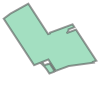

In [27]:
summarized_LDFA.geoms[0]

## CIA Data Section

In [28]:
conn = sqlite3.connect(db)
c = conn.cursor()
c.execute('''SELECT 
    parcelnumber,
    propstreetcombined,
    current_taxable,
    dda_base_val_0,
    dda_tifa_code_0
FROM ParcelDetail
WHERE TaxYear is 2018
    AND dda_tifa_code_0 is "DETROIT GATEWAY-11"''')
df = c.fetchall()
conn.close()

CIA = pd.DataFrame(df, columns = Heading)

CIA.head()

,parcelnumber,propstreetcombined,taxable,base,name
0,01008222-3,2101 W EIGHT MILE UNIT 1,4963972,1003361,DETROIT GATEWAY-11
1,01008224-5,2111 W EIGHT MILE UNIT 2,3676480,1086975,DETROIT GATEWAY-11
2,01991268.00,1335 W EIGHT MILE,34400,0,DETROIT GATEWAY-11
3,01991271.50,2111 W EIGHT MILE,287800,0,DETROIT GATEWAY-11
4,01991274.002,2023 W EIGHT MILE,0,0,DETROIT GATEWAY-11


In [29]:
polygons = []
for row in CIA.itertuples():
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''Select
                    the_geom
                FROM AssessingParcels
                WHERE 
                    PARCELNUM is '%s'
                LIMIT 1;'''%(row.parcelnumber))
    df = c.fetchall()
    conn.close()
    polygons.append(df)

len(polygons)==len(CIA) ############### ABSOLUTELY MUST BE TRUE ############### !

True

In [30]:
CIA['geom'] = [x[0] if len(x) > 0 else np.nan for x in polygons]
CIA.head()

,parcelnumber,propstreetcombined,taxable,base,name,geom
0,01008222-3,2101 W EIGHT MILE UNIT 1,4963972,1003361,DETROIT GATEWAY-11,(MULTIPOLYGON (((-83.11753933750684 42.4464988...
1,01008224-5,2111 W EIGHT MILE UNIT 2,3676480,1086975,DETROIT GATEWAY-11,(MULTIPOLYGON (((-83.12417787153625 42.4462811...
2,01991268.00,1335 W EIGHT MILE,34400,0,DETROIT GATEWAY-11,NaN
3,01991271.50,2111 W EIGHT MILE,287800,0,DETROIT GATEWAY-11,NaN
4,01991274.002,2023 W EIGHT MILE,0,0,DETROIT GATEWAY-11,NaN


In [31]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(CIA.name))
taxable = []
base = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in CIA.itertuples() if x.name == item]))
    
    # create aggregated list of bv by plan
    base.append(sum([int(x.base) for x in CIA.itertuples() if x.name == item]))
    
    # create aggregated list of cv by plan
    # ONLY BRA DOES PARCEL by PARCEL
    
    # create aggregated geometries by plan
    subList = []    
    for x in CIA.geom[CIA.name == item]:
        if type(x) == tuple:
            subList.append(shapely.wkt.loads(x[0]))
        
    geoms.append(so.cascaded_union(subList))

# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,base,geoms))
summarized_CIA = pd.DataFrame(data_tuples, columns = ['names','taxable', 'base', 'geoms'])
summarized_CIA['capture'] = summarized_CIA.taxable - summarized_CIA.base 
summarized_CIA = summarized_CIA[['names','taxable', 'base','capture','geoms']]

In [32]:
summarized_CIA.head()

,names,taxable,base,capture,geoms
0,DETROIT GATEWAY-11,12638618,2090336,10548282,POLYGON ((-83.12417787153625 42.44628115310943...


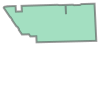

In [33]:
summarized_CIA.geoms[0]

## DDA Data Section

#### DDA Millage 

In [34]:
# DDA Mill Geoms do not necessarily pertain to capture. That dataset will not pull base values, nor calculate capture.
conn = sqlite3.connect(db)
c = conn.cursor()
c.execute('''SELECT 
                ParcelDetail.current_taxable AS Taxable,
                ParcelDetail.dda_tifa_code_0 AS Name,
                AssessingParcels.the_geom AS Shape
              FROM ParcelDetail
              LEFT JOIN 
                AssessingParcels ON ParcelDetail.parcelnumber = AssessingParcels.PARCELNUM
              WHERE ParcelDetail.TaxYear IS 2018
                AND ParcelDetail.dda_tifa_code_0 LIKE "DDA%";''')
df = c.fetchall()

#Convert results to wkt
DDA_Mill = pd.DataFrame(df, columns = ['taxable','name','geom'])
DDA_Mill.head()

,taxable,name,geom
0,0,DDA,MULTIPOLYGON (((-83.0493718960617 42.336500124...
1,3578196,DDA,MULTIPOLYGON (((-83.04606563043433 42.33105495...
2,8299800,DDA,MULTIPOLYGON (((-83.04846097076852 42.33409573...
3,321717,DDA,MULTIPOLYGON (((-83.04930814706664 42.33518340...
4,371746,DDA,MULTIPOLYGON (((-83.04947302219732 42.33539657...


In [35]:
sum([int(x) for x in list(DDA_Mill.taxable)])

1192085258

In [36]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(DDA_Mill.name))
taxable = []
base = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in DDA_Mill.itertuples() if x.name == item]))

    # create aggregated geometries by plan
    subList = []    
    for x in DDA_Mill.geom:
        try:
            subList.append(shapely.wkt.loads(x))
        except:
            pass
    geoms.append(so.cascaded_union(subList))

# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,geoms))
summarized_DDA_Mill = pd.DataFrame(data_tuples, columns = ['names','taxable', 'geoms'])
summarized_DDA_Mill.head()

,names,taxable,geoms
0,DDA,1192085258,(POLYGON ((-83.05905103054165 42.3238534549102...


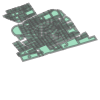

In [37]:
summarized_DDA_Mill.geoms[0]

#### DDA Capture 

In [38]:
DDA_parts = ['Z100 (TID 1-0)', 
             'Z110 (TID 1-1)',
             'Z120 (TID 1-2)',
             'Z130 (TID 1-3)',
             'Z140 (TID 1-4)',
             'Z150 (TID 1-5)',
             'Z160 (TID 1-6)',
             'Z170 (TID 1-7)',
             'Z180 (TID 1-8)']

resultsDDA = []

for expansion in DDA_parts:
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''SELECT 
        parcelnumber,
        propstreetcombined,
        current_taxable,
        dda_base_val_1,
        dda_tifa_code_1
    FROM ParcelDetail
    WHERE TaxYear is 2018
        AND dda_tifa_code_1 is '%s';'''%(expansion))
    df = c.fetchall()
    conn.close()
    resultsDDA.extend(df)

conn.close()
DDA = pd.DataFrame(resultsDDA, columns = Heading)

In [39]:
DDA.head()

,parcelnumber,propstreetcombined,taxable,base,name
0,01004105.,660 WOODWARD AVENUE,3578196,0,Z100 (TID 1-0)
1,01004110-9,1208 WOODWARD AVENUE,8299800,0,Z100 (TID 1-0)
2,01004129.,1500 WOODWARD AVENUE,321717,0,Z100 (TID 1-0)
3,01004131.,1520 WOODWARD AVENUE,371746,0,Z100 (TID 1-0)
4,01004135-6,1550 WOODWARD AVENUE,114113,0,Z100 (TID 1-0)


In [40]:
# Here we're really just trying to grab best existing polygon.
polygons = []
for row in DDA.itertuples():
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute('''Select
                    the_geom
                FROM AssessingParcels
                WHERE 
                    PARCELNUM is '%s'
                LIMIT 1;'''%(row.parcelnumber))
    df = c.fetchall()
    conn.close()
    polygons.append(df)

len(polygons)==len(DDA) ############### ABSOLUTELY MUST BE TRUE ############### !

True

In [41]:
# Add geometries to original DF, put in np.nan for null responses
DDA['geom'] = [x[0] if len(x) > 0 else np.nan for x in polygons]
DDA.head()

,parcelnumber,propstreetcombined,taxable,base,name,geom
0,01004105.,660 WOODWARD AVENUE,3578196,0,Z100 (TID 1-0),(MULTIPOLYGON (((-83.04606563043433 42.3310549...
1,01004110-9,1208 WOODWARD AVENUE,8299800,0,Z100 (TID 1-0),(MULTIPOLYGON (((-83.04846097076852 42.3340957...
2,01004129.,1500 WOODWARD AVENUE,321717,0,Z100 (TID 1-0),(MULTIPOLYGON (((-83.04930814706664 42.3351834...
3,01004131.,1520 WOODWARD AVENUE,371746,0,Z100 (TID 1-0),(MULTIPOLYGON (((-83.04947302219732 42.3353965...
4,01004135-6,1550 WOODWARD AVENUE,114113,0,Z100 (TID 1-0),(MULTIPOLYGON (((-83.04974784857106 42.3357503...


In [42]:
#Aggregating the data
# One plan, One value, many geoms - will need to merge int multipoly
names = list(set(DDA.name))
taxable = []
base = []
geoms = []
for item in names:
    
    # create aggregated list of tv by plan
    taxable.append(sum([int(x.taxable) for x in DDA.itertuples() if x.name == item]))
    
    # create aggregated list of bv by plan
    base.append(sum([int(x.base) for x in DDA.itertuples() if x.name == item]))
    
    # create aggregated list of cv by plan
    # ONLY BRA DOES PARCEL by PARCEL
    
    # create aggregated geometries by plan
    subList = []    
    for x in DDA.geom[DDA.name == item]:
        if type(x) == tuple:
            subList.append(shapely.wkt.loads(x[0]))
        
    geoms.append(so.cascaded_union(subList))

# Create list of tuples to be converted to DF
data_tuples = list(zip(names,taxable,base,geoms))
summarized_DDA = pd.DataFrame(data_tuples, columns = ['names','taxable', 'base', 'geoms'])
summarized_DDA['capture'] = summarized_DDA.taxable - summarized_DDA.base 
summarized_DDA = summarized_DDA[['names','taxable', 'base','capture','geoms']]

In [43]:
summarized_DDA

,names,taxable,base,capture,geoms
0,Z170 (TID 1-7),45483902,43337095,2146807,(POLYGON ((-83.0515267488842 42.32825029845707...
1,Z140 (TID 1-4),70729812,75933450,-5203638,(POLYGON ((-83.04806004120356 42.3282946224383...
2,Z100 (TID 1-0),464669948,94952300,369717648,(POLYGON ((-83.04480092911366 42.3294892106895...
3,Z120 (TID 1-2),57038681,2944920,54093761,(POLYGON ((-83.04274366891822 42.3331449812929...
4,Z130 (TID 1-3),89536378,20537670,68998708,(POLYGON ((-83.05905103054165 42.3238534549102...
5,Z110 (TID 1-1),19294401,9562439,9731962,(POLYGON ((-83.05721343820821 42.3253528106432...
6,Z150 (TID 1-5),6102735,1886556,4216179,(POLYGON ((-83.05551907373653 42.3366360737504...
7,Z160 (TID 1-6),25915978,5407069,20508909,(POLYGON ((-83.04798968735842 42.3409914948086...
8,Z180 (TID 1-8),30876468,6629397,24247071,(POLYGON ((-83.06129588240871 42.3376164605638...


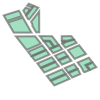

In [44]:
summarized_DDA.geoms[0]

## Data to GeoPandas

In [45]:
#____________________________________________________________LDFA
# convert the pandas df with wkt polygons to geopandas df
LDFA_gdf = geopandas.GeoDataFrame(summarized_LDFA, geometry='geoms')
LDFA_gdf.crs = {'init' :'epsg:4326'}

#____________________________________________________________DBRA
# Consolidate the Breakout of Plans
DBRA = summarized_BRA3.append(summarized_BRA1)

# convert the pandas df with wkt polygons to geopandas df
DBRA_gdf = geopandas.GeoDataFrame(DBRA, geometry='geoms')
DBRA_gdf.crs = {'init' :'epsg:4326'}

#____________________________________________________________CIA
# convert the pandas df with wkt polygons to geopandas df
CIA_gdf = geopandas.GeoDataFrame(summarized_CIA, geometry='geoms')
CIA_gdf.crs = {'init' :'epsg:4326'}

#____________________________________________________________DDA Mills
# convert the pandas df with wkt polygons to geopandas df
DDA_Mill_gdf = geopandas.GeoDataFrame(summarized_DDA_Mill, geometry='geoms')
DDA_Mill_gdf.crs = {'init' :'epsg:4326'}

#____________________________________________________________DDA Capture
# convert the pandas df with wkt polygons to geopandas df
summarized_DDA_gdf = geopandas.GeoDataFrame(summarized_DDA, geometry='geoms')
summarized_DDA_gdf.crs = {'init' :'epsg:4326'}

#### Convert Authorities to Shapefile (ArcGIS)

In [46]:
# Write to files as Shapefile
DBRA_gdf.to_file("< LINK TO >TY2018_DBRA.shp")

LDFA_gdf.to_file("< LINK TO >TY2018_LDFA.shp")

CIA_gdf.to_file("< LINK TO >TY2018_CIA.shp")

DDA_Mill_gdf.to_file("< LINK TO >TY2018_Whole_DDA.shp")

summarized_DDA_gdf.to_file("< LINK TO >TY2018_Capture_DDA.shp")

#### Convert Authorities to GeoJson (Leaflet)

In [47]:
# DELETE OLD GEOJSONS First!!!
# Will not overwrite

# Write to file as geojson
DBRA_gdf.to_file("< LINK TO >TY2018_DBRA.geojson", driver='GeoJSON')

# Write to file as geojson
LDFA_gdf.to_file("< LINK TO >TY2018_LDFA.geojson", driver='GeoJSON')

# Write to file as geojson
CIA_gdf.to_file("< LINK TO >TY2018_CIA.geojson", driver='GeoJSON')

# Write to file as geojson
DDA_Mill_gdf.to_file("< LINK TO >TY2018_Whole_DDA.geojson", driver='GeoJSON')

# Write to file as geojson
summarized_DDA_gdf.to_file("< LINK TO >TY2018_Capture_DDA.geojson", driver='GeoJSON')

In [48]:
# Get rid of any old verion. GeoJsons do not like being overwritten

# Before getting into it, we'll need a highlight function
def highlight_function(feature):
    return {
        'fillColor': '#ffaf00',
        'color': 'green',
        'weight': 1.1,
    }

#Set up map
#CENTER = [42.3318175,-83.0465565] # Downtown
CENTER = [42.3702657,-83.0738462] # Citywide

m = folium.Map(CENTER, zoom_start=12, tiles='cartodbpositron')

# Open GeoJson

with open("< LINK TO >TY2018_DBRA.geojson") as f:
    DBRA = json.load(f)

with open("< LINK TO >TY2018_LDFA.geojson") as f:
    LDFA = json.load(f)

with open("< LINK TO >TY2018_CIA.geojson") as f:
    CIA = json.load(f)

with open("< LINK TO >TY2018_Whole_DDA.geojson") as f:
    DDA = json.load(f)

with open("< LINK TO >TY2018_Capture_DDA.geojson") as f:
    TIDs = json.load(f)

with open("< LINK TO >CoD_Dissolved.geojson") as f:
    Bounds = json.load(f)

In [49]:
# Add Layers
Bounds_leaf = folium.GeoJson(Bounds,
        name = 'City Limits',
        style_function=lambda data: {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0,}).add_to(m)

DDA_leaf = folium.GeoJson(DDA,
        name = 'DDA',
        style_function=lambda data: {
            'fillColor': 'grey',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1,},
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
        fields=['taxable', 'names'],
        localize=True)).add_to(m)

LDFA_leaf = folium.GeoJson(LDFA,
        name = 'LDFA',
        style_function=lambda data: {
            'fillColor': 'yellow',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.2,},
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
        fields=['names','taxable','base','capture'],
        localize=True)).add_to(m)

CIA_leaf = folium.GeoJson(CIA,
        name = 'CIA',
        style_function=lambda data: {
            'fillColor': 'purple',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.2,},
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
        fields=['names','taxable','base','capture'],
        localize=True)).add_to(m)

TIDs_leaf = folium.GeoJson(TIDs,
        name = 'Tax Increment DDA',
        style_function=lambda data: {
            'fillColor': 'red',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.15,},
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
        fields=['names','taxable','base','capture'],
        localize=True)).add_to(m)

DBRA_leaf = folium.GeoJson(DBRA,
        name = 'Brownfields',
        style_function=lambda data: {
            'fillColor': 'dark green',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.4,},
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
        fields=['names','taxable','base','capture'],
        localize=True)).add_to(m)

#Folium Search got an update
DBRA_search = plugins.Search(
    position='bottomleft',
    layer = DBRA_leaf, 
    geom_type = 'Polygon',
    placeholder='DBRA Projects',
    search_label = "names", 
    search_zoom=17).add_to(m)

#minimap = plugins.MiniMap(position = 'bottomleft')
#m.add_child(minimap)

# Layer Control
folium.LayerControl().add_to(m)

m

In [50]:
m.save('TY2018 All Capture Projects.html')